In [ ]:
# This is a sample Python script.

# Press Shift+F10 to execute it or replace it with your code.
# Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.


def print_hi(name):
    # Use a breakpoint in the code line below to debug your script.
    print(f'Hi, {name}')  # Press Ctrl+F8 to toggle the breakpoint.


# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    print_hi('PyCharm')

# See PyCharm help at https://www.jetbrains.com/help/pycharm/


In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

keras.utils.set_random_seed(42)

In [5]:
import requests

url = 'https://dl.dropbox.com/scl/fi/e2ik6aryemboameq1rwwn/fer2013.csv?rlkey=ux7tyge6flk9nnuul9desizgf&dl=0'
destination = 'fer2013.csv'

response = requests.get(url)
if response.status_code == 200:
    with open(destination, 'wb') as f:
        f.write(response.content)


In [6]:
data = pd.read_csv('fer2013.csv')
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [7]:
len(data.loc[0,'pixels'].split(' '))

2304

In [8]:
pixels = data['pixels'].tolist()
width,height = 48,48
faces=[]
for pixel_sequence in pixels:
    face=[int(pixel) for pixel in pixel_sequence.split(' ')]
    face=np.asarray(face).reshape(width,height)
    face=np.stack((face,)*3,axis=-1)
    faces.append(face.astype('float32'))

faces = np.asarray(faces)
faces.shape

(35887, 48, 48, 3)

In [9]:
faces[0,:,:,0]

array([[ 70.,  80.,  82., ...,  52.,  43.,  41.],
       [ 65.,  61.,  58., ...,  56.,  52.,  44.],
       [ 50.,  43.,  54., ...,  49.,  56.,  47.],
       ...,
       [ 91.,  65.,  42., ...,  72.,  56.,  43.],
       [ 77.,  82.,  79., ..., 105.,  70.,  46.],
       [ 77.,  72.,  84., ..., 106., 109.,  82.]],
      shape=(48, 48), dtype=float32)

In [10]:
data.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [11]:
emotions=pd.get_dummies(data['emotion']).to_numpy()
emotions_names = ('angry','disgust','fear','happy','sad','surprise','neutral')
emotions.shape

(35887, 7)

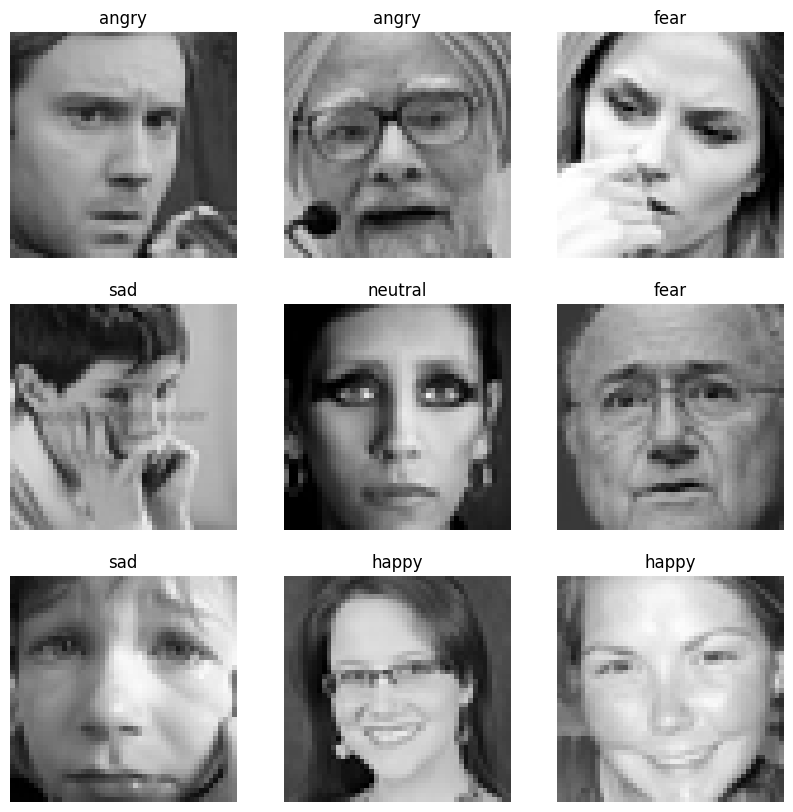

In [12]:
fig = plt.figure(figsize=(10,10))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    ax.set_title(f"{emotions_names[np.argmax(emotions[i])]}")
    ax.imshow(faces[i].astype('uint8'))
    ax.axis('off')

In [13]:
train_faces,train_emotions = faces[:28709],emotions[:28709]
test_faces,test_emotions = faces[28709:],emotions[28709:]

train_faces.shape,train_emotions.shape,test_faces.shape,test_emotions.shape


((28709, 48, 48, 3), (28709, 7), (7178, 48, 48, 3), (7178, 7))

In [21]:
inputs =keras.Input(shape=(48,48,3),name="input")
x = keras.layers.Rescaling(1./255)(inputs)
x = keras.layers.Conv2D(16,                    # Number of filters
                        kernel_size=(2, 2),    # The shape of each filter
                        activation="relu",     # RELU activation as usual
                        name="Conv_1")(x)
# pooling layer
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(16,                    # Number of filters
                        kernel_size=(2, 2),    # The shape of each filter
                        activation="relu",     # RELU activation as usual
                        name="Conv_2")(x)
# pooling layer
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(16,                    # Number of filters
                        kernel_size=(2, 2),    # The shape of each filter
                        activation="relu",     # RELU activation as usual
                        name="Conv_3")(x)
# pooling layer
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Flatten()(x)

# fully-connected (dense) ReLU layer
x = keras.layers.Dense(256, activation="relu")(x)

# output softmax layer
output = keras.layers.Dense(7, activation="softmax",name='output')(x)
model= keras.Model(inputs,output,name='CNN_model')
model.summary()

Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_1 (Conv2D)                 │ (None, 47, 47, 16)     │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 22, 22, 16)     │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 11, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_3 (Conv2D)                 │ (None, 10, 10, 16)     │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       102,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,743 (416.96 KB)

 Trainable params: 106,743 (416.96 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_history = model.fit(x=train_faces,y=train_emotions,batch_size=64,epochs=30,validation_split=0.2)

Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3097 - loss: 1.7140 - val_accuracy: 0.3929 - val_loss: 1.5913
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4039 - loss: 1.5445 - val_accuracy: 0.4213 - val_loss: 1.5082
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4382 - loss: 1.4615 - val_accuracy: 0.4514 - val_loss: 1.4375
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4642 - loss: 1.3949 - val_accuracy: 0.4660 - val_loss: 1.3919
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4873 - loss: 1.3370 - val_accuracy: 0.4814 - val_loss: 1.3610
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5083 - loss: 1.2896 - val_accuracy: 0.4894 - val_loss: 1.3394
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5266 - loss: 1.2449 - val_accuracy: 0.4929 - val_loss: 1.3271
Epoch 8/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5462 - loss: 1.2045 - val_accuracy: 0

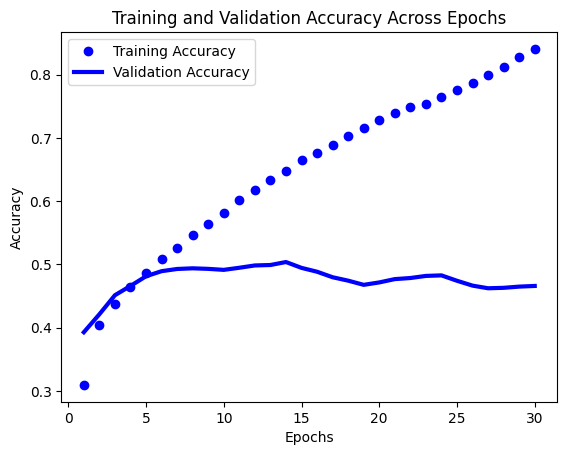

In [23]:
def plot_accuracy(model_history):
    history_dict = model_history.history
    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, "bo", label="Training Accuracy", linewidth=3)
    plt.plot(epochs, val_acc, "b", label="Validation Accuracy", linewidth=3)
    plt.title("Training and Validation Accuracy Across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_accuracy(model_history)

In [24]:
model.evaluate(test_faces, test_emotions)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4787 - loss: 2.2927


[2.292668342590332, 0.4786848723888397]

In [29]:
inputs =keras.Input(shape=(48,48,3),name="input")
x = keras.layers.Rescaling(1./255)(inputs)
x = keras.layers.Conv2D(32,                    # Number of filters
                        kernel_size=(2, 2),    # The shape of each filter
                        activation="relu",     # RELU activation as usual
                        name="Conv_1")(x)
# pooling layer
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(32,                    # Number of filters
                        kernel_size=(2, 2),    # The shape of each filter
                        activation="relu",     # RELU activation as usual
                        name="Conv_2")(x)
# pooling layer
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(32,                    # Number of filters
                        kernel_size=(2, 2),    # The shape of each filter
                        activation="relu",     # RELU activation as usual
                        name="Conv_3")(x)
# pooling layer
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Flatten()(x)

# fully-connected (dense) ReLU layer
x = keras.layers.Dense(256, activation="relu")(x)

# output softmax layer
output = keras.layers.Dense(7, activation="softmax",name='output')(x)
wider_model= keras.Model(inputs,output,name='wider_CNN')
wider_model.summary()

Model: "wider_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_1 (Conv2D)                 │ (None, 47, 47, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 22, 22, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_3 (Conv2D)                 │ (None, 10, 10, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,527 (841.90 KB)

 Trainable params: 215,527 (841.90 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
wider_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
wider_model_history = wider_model.fit(x=train_faces,y=train_emotions,batch_size=64,epochs=30,validation_split=0.2)

Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3203 - loss: 1.6986 - val_accuracy: 0.4086 - val_loss: 1.5584
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4238 - loss: 1.4980 - val_accuracy: 0.4485 - val_loss: 1.4555
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4666 - loss: 1.3873 - val_accuracy: 0.4794 - val_loss: 1.3643
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4995 - loss: 1.3098 - val_accuracy: 0.4998 - val_loss: 1.3141
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5254 - loss: 1.2485 - val_accuracy: 0.5096 - val_loss: 1.2794
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5538 - loss: 1.1904 - val_accuracy: 0.5230 - val_loss: 1.2611
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5762 - loss: 1.1367 - val_accuracy: 0.5333 - val_loss: 1.2562
Epoch 8/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6004 - loss: 1.0770 - val_accu

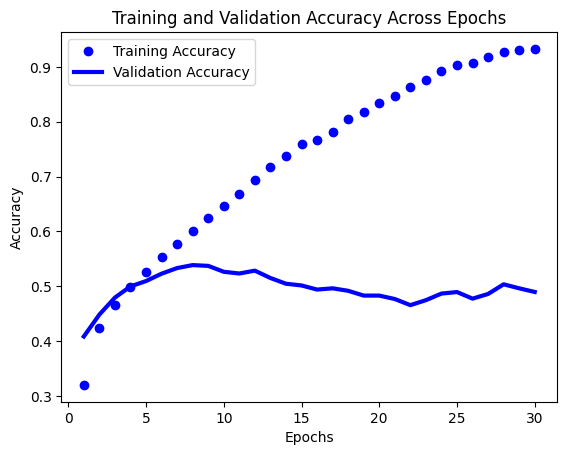

In [32]:
plot_accuracy(wider_model_history)

In [33]:
wider_model.evaluate(test_faces,test_emotions)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4968 - loss: 3.5355


[3.5354793071746826, 0.49679577350616455]

In [35]:
inputs =keras.Input(shape=train_faces.shape[1:],name="input")
x = keras.layers.Rescaling(1./255)(inputs)
x = keras.layers.Conv2D(16,                    # Number of filters
                        kernel_size=(2, 2),    # The shape of each filter
                        activation="relu",     # RELU activation as usual
                        name="Conv_1")(x)
# pooling layer
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(16,                    # Number of filters
                        kernel_size=(2, 2),    # The shape of each filter
                        activation="relu",     # RELU activation as usual
                        name="Conv_2")(x)
# pooling layer
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(16,                    # Number of filters
                        kernel_size=(2, 2),    # The shape of each filter
                        activation="relu",     # RELU activation as usual
                        name="Conv_3")(x)
# pooling layer
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Flatten()(x)

# fully-connected (dense) ReLU layer
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(256, activation="relu")(x)

# output softmax layer
output = keras.layers.Dense(7, activation="softmax",name='output')(x)
deeper_model= keras.Model(inputs,output,name='deeper_cnn')
deeper_model.summary()

Model: "deeper_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_1 (Conv2D)                 │ (None, 47, 47, 16)     │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 22, 22, 16)     │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 11, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_3 (Conv2D)                 │ (None, 10, 10, 16)     │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       102,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,535 (673.96 KB)

 Trainable params: 172,535 (673.96 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
deeper_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
deeper_model_history = deeper_model.fit(x=train_faces,y=train_emotions,batch_size=64,epochs=30,validation_split=0.2)

Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2942 - loss: 1.7353 - val_accuracy: 0.3699 - val_loss: 1.6007
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3991 - loss: 1.5472 - val_accuracy: 0.4119 - val_loss: 1.5108
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4359 - loss: 1.4541 - val_accuracy: 0.4448 - val_loss: 1.4341
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4675 - loss: 1.3727 - val_accuracy: 0.4599 - val_loss: 1.3865
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4976 - loss: 1.3007 - val_accuracy: 0.4751 - val_loss: 1.3606
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5251 - loss: 1.2360 - val_accuracy: 0.4791 - val_loss: 1.3545
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5517 - loss: 1.1707 - val_accuracy: 0.4906 - val_loss: 1.3522
Epoch 8/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5833 - loss: 1.1053 - val_accuracy: 0.

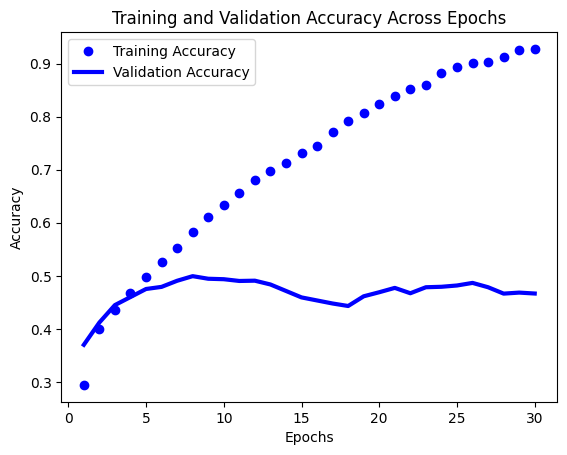

In [37]:
plot_accuracy(deeper_model_history)

In [38]:
deeper_model.evaluate(test_faces,test_emotions)

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4677 - loss: 3.7154


[3.7153704166412354, 0.4676790237426758]

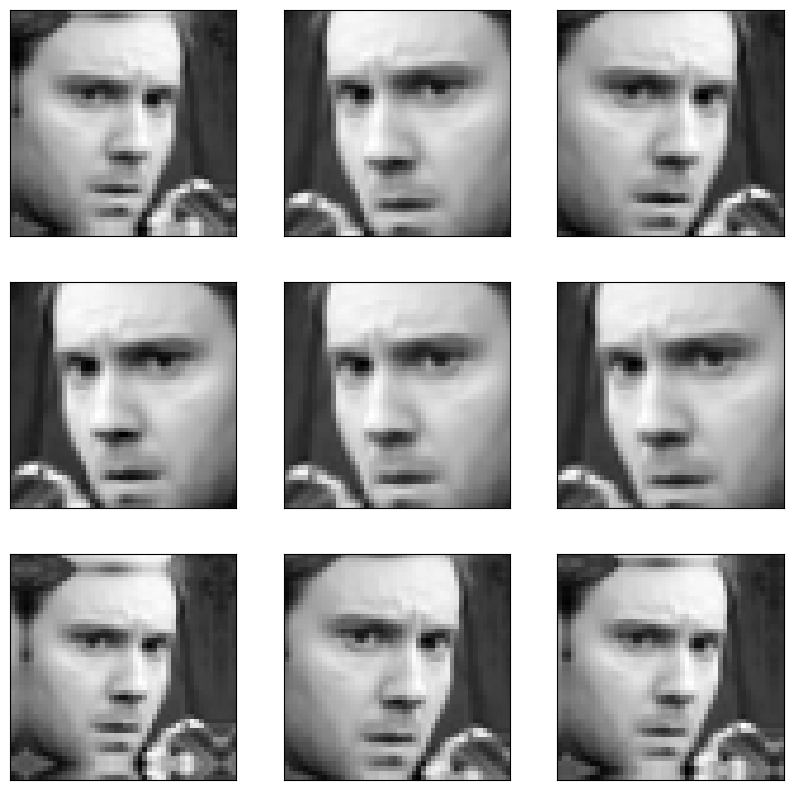

In [39]:
def augment_images(image):
    x = keras.layers.RandomFlip("horizontal")(image)
    x = keras.layers.RandomZoom(0.2)(x)
    return x

augmented_images = [augment_images(np.expand_dims(train_faces[0],axis=0)) for i in range(9)]
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    ax.imshow(tf.keras.preprocessing.image.array_to_img(augmented_images[i][0]), cmap='gray', vmin=0, vmax=255)

In [40]:
inputs = keras.Input(shape=(48, 48, 3))

### DATA AUGMENTATION ###
x = keras.layers.RandomFlip("horizontal")(inputs)
x = keras.layers.RandomZoom(0.2)(x)
x = keras.layers.Rescaling(1./255)(x)
x = keras.layers.Conv2D(32,                    # Number of filters
                        kernel_size=(2, 2),    # The shape of each filter
                        activation="relu",     # RELU activation as usual
                        name="Conv_1")(x)
# pooling layer
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(32,                    # Number of filters
                        kernel_size=(2, 2),    # The shape of each filter
                        activation="relu",     # RELU activation as usual
                        name="Conv_2")(x)
# pooling layer
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(32,                    # Number of filters
                        kernel_size=(2, 2),    # The shape of each filter
                        activation="relu",     # RELU activation as usual
                        name="Conv_3")(x)
# pooling layer
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Flatten()(x)

# fully-connected (dense) ReLU layer
x = keras.layers.Dense(256, activation="relu")(x)

# output softmax layer
output = keras.layers.Dense(7, activation="softmax",name='output')(x)


model_augmented = keras.Model(inputs, output, name='augmented_CNN_model')
model_augmented.summary()

Model: "augmented_CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_9 (RandomFlip)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_9 (RandomZoom)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_1 (Conv2D)                 │ (None, 47, 47, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 22, 22, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_3 (Conv2D)                 │ (None, 10, 10, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,527 (841.90 KB)

 Trainable params: 215,527 (841.90 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model_augmented.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_augmented_history = model_augmented.fit(x=train_faces,y=train_emotions,batch_size=64,epochs=30,validation_split=0.2)

Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3005 - loss: 1.7333 - val_accuracy: 0.3868 - val_loss: 1.6042
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3885 - loss: 1.5800 - val_accuracy: 0.4373 - val_loss: 1.4935
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4287 - loss: 1.4899 - val_accuracy: 0.4657 - val_loss: 1.4178
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.4528 - loss: 1.4244 - val_accuracy: 0.4789 - val_loss: 1.3610
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4744 - loss: 1.3751 - val_accuracy: 0.4937 - val_loss: 1.3203
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4911 - loss: 1.3348 - val_accuracy: 0.4986 - val_loss: 1.2996
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5013 - loss: 1.3074 - val_accuracy: 0.5125 - val_loss: 1.2689
Epoch 8/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5115 - loss: 1.2805 - val_accu

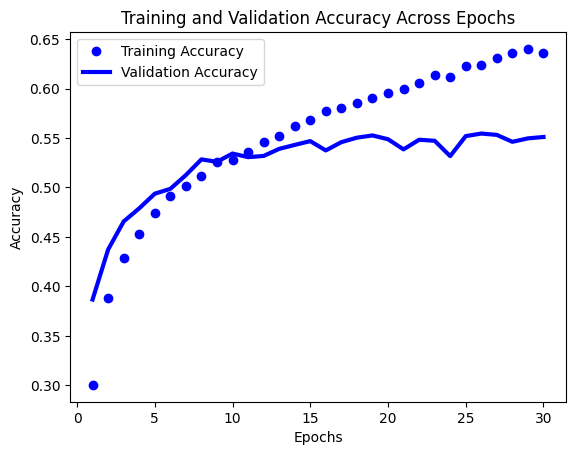

In [42]:
plot_accuracy(model_augmented_history)

In [43]:
model_augmented.evaluate(test_faces,test_emotions)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5424 - loss: 1.2436


[1.2435582876205444, 0.5423516035079956]

In [44]:
base_model = keras.applications.VGG19(
    include_top=False,   # this makes VGG19 headless
    weights="imagenet",
    input_tensor=None,
    input_shape=(48, 48, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

# Freeze the base_model so that it is not trainable at all
base_model.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [46]:
inputs = keras.Input(shape=(48,48,3))

x = keras.layers.RandomFlip("horizontal")(inputs)
x = keras.layers.RandomZoom(0.2)(x)
x = keras.layers.Rescaling(1./255)(x) # normalizing

# Add layers from base_model one at a time
x = base_model(x, training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(7, activation='softmax')(x)

transfer_model = keras.Model(inputs, outputs, name='transfer_model')
transfer_model.summary()

Model: "transfer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_11 (RandomFlip)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_11 (RandomZoom)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_11 (Rescaling)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 1, 1, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,157,511 (76.89 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [47]:
transfer_model.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(2e-5),
            metrics=['accuracy'])

transfer_model_history = transfer_model.fit(train_faces, train_emotions, epochs=30, validation_split=0.2)

Epoch 1/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 141s 195ms/step - accuracy: 0.2295 - loss: 1.8561 - val_accuracy: 0.2926 - val_loss: 1.7402
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 146s 203ms/step - accuracy: 0.2997 - loss: 1.7321 - val_accuracy: 0.3250 - val_loss: 1.6937
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 150s 208ms/step - accuracy: 0.3197 - loss: 1.7021 - val_accuracy: 0.3352 - val_loss: 1.6687
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 157s 218ms/step - accuracy: 0.3300 - loss: 1.6844 - val_accuracy: 0.3424 - val_loss: 1.6535
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 148s 206ms/step - accuracy: 0.3344 - loss: 1.6726 - val_accuracy: 0.3473 - val_loss: 1.6428
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 152s 211ms/step - accuracy: 0.3391 - loss: 1.6628 - val_accuracy: 0.3530 - val_loss: 1.6334
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 154s 214ms/step - accuracy: 0.3419 - loss: 1.6558 - val_accuracy: 0.3535 - val_loss: 1.6272
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 146s 203ms/step - accuracy: 0.3451 -

KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
plot_accuracy(transfer_model_history)

In [ ]:
from IPython.display import display

def show_confusion_matrix(model):
    """
    Calculates the test accuracy, confusion matrix and heat map for a model.
    """
    global test_faces, test_emotions, emotions_names

    y_pred = model.predict(test_faces).argmax(axis=1)
    y_actual = test_emotions.argmax(axis=1)

    print('*************************\n* Test Accuracy: %.4f *\n*************************' % metrics.accuracy_score(y_actual, y_pred))

    cm = pd.DataFrame(metrics.confusion_matrix(y_actual, y_pred), index=emotions_names, columns=emotions_names)
    display(cm)

    cm = cm.div(cm.sum(axis=1), axis=0)

    sns.heatmap(cm, cmap="Blues", annot=True, fmt=".2f")

show_confusion_matrix(transfer_model)

In [54]:
base_model = keras.applications.VGG19(
    include_top=False,   # this makes VGG19 headless
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

inputs = keras.Input(shape=(48,48,3))

x = keras.layers.RandomFlip("horizontal")(inputs)
x = keras.layers.RandomZoom(0.2)(x)
x = keras.layers.Rescaling(1./255)(x) # normalizing
for layer in base_model.layers[:15]:
    layer.trainable = False
# Add layers from base_model
x=base_model(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(7, activation='softmax')(x)

partial_model = keras.Model(inputs, outputs, name='partial_fine_tune_model')


partial_model.summary()

Model: "partial_fine_tune_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_18 (RandomFlip)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_18 (RandomZoom)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_18 (Rescaling)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 1, 1, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,157,511 (76.89 MB)

 Trainable params: 11,932,167 (45.52 MB)

 Non-trainable params: 8,225,344 (31.38 MB)

In [ ]:
for i, layer in enumerate(partial_model.layers):
    print('Layer %d: %s (%s), Trainable=%s' % (i+1, layer.name, layer.__class__.__name__, layer.trainable))

In [ ]:
partial_model.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(2e-5),
            metrics=['accuracy'])

partial_model_history = partial_model.fit(train_faces, train_emotions, epochs=30, validation_split=0.2)

In [ ]:
plot_accuracy(partial_model_history)

In [ ]:
show_confusion_matrix(partial_model)

In [51]:
base_model = keras.applications.VGG19(
    include_top=False,   # this makes VGG19 headless
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

inputs = keras.Input(shape=(48,48,3))

x = keras.layers.RandomFlip("horizontal")(inputs)
x = keras.layers.RandomZoom(0.2)(x)
x = keras.layers.Rescaling(1./255)(x) # normalizing

x=base_model(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(7, activation='softmax')(x)

tuned_model = keras.Model(inputs, outputs, name='full_fine_tune_model')
tuned_model.summary()
# Let's see which layers are trainable
for i, layer in enumerate(tuned_model.layers):
    print('Layer %d: %s (%s), Trainable=%s' % (i+1, layer.name, layer.__class__.__name__, layer.trainable))

Model: "full_fine_tune_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_15 (RandomFlip)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_15 (RandomZoom)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_15 (Rescaling)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 1, 1, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,157,511 (76.89 MB)

 Trainable params: 20,157,511 (76.89 MB)

 Non-trainable params: 0 (0.00 B)

Layer 1: input_layer_11 (InputLayer), Trainable=True
Layer 2: random_flip_15 (RandomFlip), Trainable=True
Layer 3: random_zoom_15 (RandomZoom), Trainable=True
Layer 4: rescaling_15 (Rescaling), Trainable=True
Layer 5: vgg19 (Functional), Trainable=True
Layer 6: flatten_17 (Flatten), Trainable=True
Layer 7: dense_24 (Dense), Trainable=True
Layer 8: dense_25 (Dense), Trainable=True


In [ ]:
tuned_model.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(2e-5),
            metrics=['accuracy'])

tuned_model_history = tuned_model.fit(train_faces, train_emotions, epochs=30, validation_split=0.2)

In [ ]:
plot_accuracy(tuned_model_history)

In [ ]:
show_confusion_matrix(tuned_model)